In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
!pip install git+https://github.com/pbloem/kgbench-loader.git


  Cloning https://github.com/pbloem/kgbench-loader.git to /tmp/pip-req-build-3e6m58fp
  Running command git clone --filter=blob:none --quiet https://github.com/pbloem/kgbench-loader.git /tmp/pip-req-build-3e6m58fp
  Resolved https://github.com/pbloem/kgbench-loader.git to commit 320e614c6df0fee0ab8806b40b1770b7fa1f4ca8
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 13.5 MB/s eta 0:00:0000:01
  Created wheel for kgbench: filename=kgbench-0.2-py3-none-any.whl size=14130 sha256=79f9b4fefe4a83848fc105fe604c1f05e88fc0bf459f7dac27938257409e531b
  Stored in directory: /tmp/pip-ephem-wheel-cache-u35_7ifm/wheels/2f/0a/92/a69d7eeae6ebfcca1fb8a15f654543f3be94bfd3393ff36ff7
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=b70983a1ef467ac958474810ed981b1c

In [9]:
import kgbench as kg

# Load the 'amplus' dataset with numpy arrays and train/validation split
data = kg.load('amplus')

# If you prefer PyTorch tensors
# data = kg.load('amplus', torch=True)

# For train/test split
# data = kg.load('amplus', final=True)

# Verify the dataset
print(f'Number of entities: {data.num_entities}')
print(f'Number of relations: {data.num_relations}')
print(f'Number of classes: {data.num_classes}')


loaded data amplus (46.66s).
Number of entities: 1153679
Number of relations: 33
Number of classes: 8


In [10]:
!pip install torch
!pip install torch-geometric


In [11]:
# 1. Import Libraries
# ========================
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Import HuggingFace transformer libraries for pre-trained language model
from transformers import AutoTokenizer, AutoModel

In [12]:
# 3. Extract and Preprocess Entity Texts
# ========================
# Extract textual information from each entity (each entity is stored as a tuple/list)
entity_texts = [entity[0].strip() for entity in data.i2e]

# For a quick look, print first 5 entity texts
for i in range(min(5, len(entity_texts))):
    print(f"Entity {i}: {entity_texts[i]}")

# Define a simple function to infer entity types (used for one-hot features)
def infer_entity_type(text):
    if not text:
        return "Empty"
    elif "(" in text and ")" in text:
        return "Parenthetical"
    elif any(char.isdigit() for char in text):
        return "Numeric"
    elif len(text.split()) > 5:
        return "Descriptive"
    else:
        return "Other"

entity_types = [infer_entity_type(text) for text in entity_texts]

Entity 0: 
Entity 1: 
Entity 2: sokkel in dep 3 kast 25
Entity 3: (1534-1603)
Entity 4: (4 talen)


In [13]:
# 4. Compute One-Hot Features for Entity Types
# ========================
unique_types = list(set(entity_types))
type_to_idx = {t: idx for idx, t in enumerate(unique_types)}
one_hot_features = F.one_hot(torch.tensor([type_to_idx[t] for t in entity_types]),
                             num_classes=len(unique_types)).float()

In [15]:
# 5. Compute Language Embeddings using a Pre-trained Model
# ========================
# We'll use a pre-trained sentence transformer model to extract semantic embeddings.
# Model: 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model_hf = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model_hf.eval()  # set model to evaluation mode

# Move the HuggingFace model to the same device later; for now, we use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_hf.to(device)

# Define a mean pooling function to obtain sentence embeddings from token embeddings
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # first element: token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    # Sum embeddings and divide by the total number of tokens (avoid division by zero)
    return torch.sum(token_embeddings * input_mask_expanded, dim=1) / torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)

# Process texts in batches to avoid memory issues (adjust batch_size as needed)
batch_size = 32
lang_embeddings_list = []

with torch.no_grad():
    for i in range(0, len(entity_texts), batch_size):
        batch_texts = entity_texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        # Move inputs to the same device as model_hf
        encoded_input = {key: value.to(device) for key, value in encoded_input.items()}
        model_output = model_hf(**encoded_input)
        # Perform mean pooling on token embeddings to get sentence embeddings
        batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        # Move embeddings to CPU and store them
        lang_embeddings_list.append(batch_embeddings.cpu())

# Concatenate all batch results into a single tensor
lang_embeddings = torch.cat(lang_embeddings_list, dim=0)
print(f"Language embeddings shape: {lang_embeddings.shape}")
# For example, if using 'all-MiniLM-L6-v2', each embedding is 384-dimensional.

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Language embeddings shape: torch.Size([1153679, 384])


In [16]:
# 6. Combine One-Hot Features and Language Embeddings
# ========================
# Concatenate along the feature dimension.
# New feature dimension = (number of one-hot dims) + (language embedding dim)
combined_features = torch.cat([one_hot_features, lang_embeddings], dim=1)
print(f"Combined node features shape: {combined_features.shape}")

Combined node features shape: torch.Size([1153679, 389])


In [17]:
# 7. Prepare Graph Data for GNN
# ========================
# Build the edge index from triples. Each triple is (source, relation, target).
edge_index = torch.tensor([[triple[0] for triple in data.triples],
                           [triple[2] for triple in data.triples]], dtype=torch.long)

# Use the same labels as before (based on inferred entity types) for node classification
labels = torch.tensor([type_to_idx[t] for t in entity_types])

# Create train/test masks (80% train, 20% test)
train_idx, test_idx = train_test_split(range(data.num_entities), test_size=0.2, random_state=42)
train_mask = torch.zeros(data.num_entities, dtype=torch.bool)
test_mask = torch.zeros(data.num_entities, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# Create the PyTorch Geometric Data object with the combined features
graph_data = Data(x=combined_features, edge_index=edge_index, y=labels,
                  train_mask=train_mask, test_mask=test_mask)

# Move graph_data to the same device used for training
graph_data = graph_data.to(device)


In [18]:
# 8. Define the Enhanced GCN Model
# ========================
# Since our new node features have dimension = len(unique_types) + language_embedding_dim,
# we must update the input dimension accordingly.
input_dim = combined_features.shape[1]  # one-hot dim + language embedding dim
hidden_dim = 16
output_dim = len(unique_types)  # using the inferred entity types as labels

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate the model and move it to the device
model = GCN(input_dim, hidden_dim, output_dim).to(device)

In [19]:
# 9. Set Up Optimizer and Loss Function
# ========================
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

In [22]:
# 10. Training and Evaluation Functions
# ========================
loss_history = []
accuracy_history = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits = model(graph_data.x, graph_data.edge_index)
    pred = logits.argmax(dim=1)
    correct = (pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]).sum()
    acc = int(correct) / int(graph_data.test_mask.sum())
    return acc

# Training loop: 200 epochs
for epoch in range(1, 301):
    loss = train()
    loss_history.append(loss)
    if epoch % 10 == 0:
        acc = test()
        accuracy_history.append(acc)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

Epoch 10, Loss: 0.1307, Test Accuracy: 0.9648
Epoch 20, Loss: 0.1249, Test Accuracy: 0.9719
Epoch 30, Loss: 0.1197, Test Accuracy: 0.9740
Epoch 40, Loss: 0.1152, Test Accuracy: 0.9742
Epoch 50, Loss: 0.1114, Test Accuracy: 0.9747
Epoch 60, Loss: 0.1081, Test Accuracy: 0.9761
Epoch 70, Loss: 0.1049, Test Accuracy: 0.9793
Epoch 80, Loss: 0.1018, Test Accuracy: 0.9821
Epoch 90, Loss: 0.0983, Test Accuracy: 0.9839
Epoch 100, Loss: 0.0946, Test Accuracy: 0.9854
Epoch 110, Loss: 0.0908, Test Accuracy: 0.9866
Epoch 120, Loss: 0.0877, Test Accuracy: 0.9873
Epoch 130, Loss: 0.0843, Test Accuracy: 0.9887
Epoch 140, Loss: 0.0817, Test Accuracy: 0.9891
Epoch 150, Loss: 0.0796, Test Accuracy: 0.9896
Epoch 160, Loss: 0.0776, Test Accuracy: 0.9900
Epoch 170, Loss: 0.0759, Test Accuracy: 0.9903
Epoch 180, Loss: 0.0744, Test Accuracy: 0.9903
Epoch 190, Loss: 0.0732, Test Accuracy: 0.9908
Epoch 200, Loss: 0.0719, Test Accuracy: 0.9910
Epoch 210, Loss: 0.0707, Test Accuracy: 0.9909
Epoch 220, Loss: 0.069

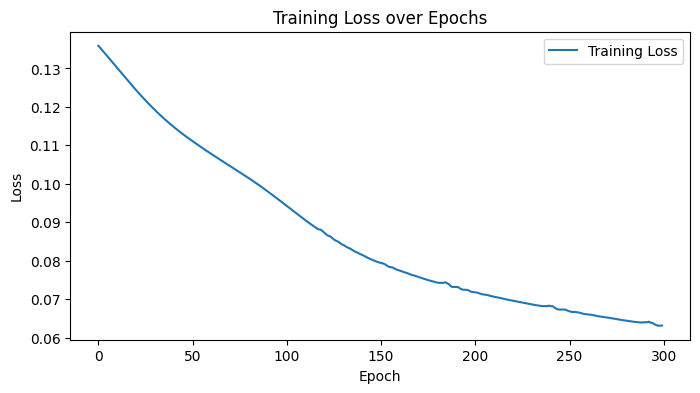

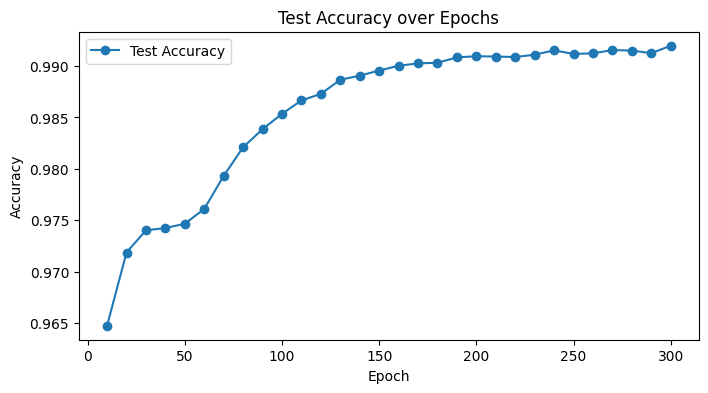

In [25]:
# 11. Plot Training Metrics
# ========================
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(10, 301, 10), accuracy_history, marker='o', label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
